In [1]:
%matplotlib inline
import numpy as np
import random
import time
from keras.models import load_model
from scipy import fftpack
import os, sys
import scipy.ndimage as ndimage
import healpy as hp
from astropy.io import fits
from importlib import reload 
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy import interpolate

import gc

import matplotlib.pyplot as plt

# sys path prepend and reload are for development
sys.path = ['../'] + sys.path
print(sys.path)

Using TensorFlow backend.


['../', '', '/Users/ucapnje/anaconda3/lib/python36.zip', '/Users/ucapnje/anaconda3/lib/python3.6', '/Users/ucapnje/anaconda3/lib/python3.6/lib-dynload', '/Users/ucapnje/.local/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/aeosa', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/pydelfi-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/deepmass-0.1-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/skymapper-0.3.2-py3.6.egg', '/Users/ucapnje/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/Users/ucapnje/.ipython']


In [2]:
1.13

1.13

In [3]:
# sys path prepend and reload are for development

from deepmass import map_functions as mf
from deepmass import lens_data as ld
from deepmass import wiener

reload(mf)
reload(ld)
reload(wiener)

<module 'deepmass.wiener' from '../deepmass/wiener.py'>

# Load model

In [4]:
# trained_model_file = '../outputs/h5_files/model_unet_weights_simplest3e-06.h5'
trained_model_file = '../outputs/h5_files/model_unet_simplest1e-05.h5'

In [5]:
model = load_model(trained_model_file)

In [6]:
def apply_deepmass(wiener_map, model):
    
    array_wiener = np.empty((1,256,256,1))
    array_wiener[0,:,:,0] = np.array(wiener_map, dtype = 'float32')
    array_wiener = mf.rescale_map(array_wiener, 3.0, 0.5, clip=False)
    _ = np.clip(array_wiener, 0.,1., out=array_wiener)

    output = model.predict(array_wiener[:, :, :, :])
    return  mf.rescale_map(output, 3.0,0.5, invert=True)[0,:,:,0]

# Prepare data

In [7]:
power_map = np.load('../picola_training/power_map_y1_fiducial.npy')
Ncov = np.load('../picola_training/Ncov.npy')
count_gnomview = np.load('count_gnomview.npy')

In [8]:
mice_power = np.load('projected_mice_power_noisy2.npy')
mice_power_map = mf.compute_spectrum_map(mice_power, 256)

In [9]:
e1_map = np.load('../misc_data/e1_projected_des_data.npy')
e2_map = np.load('../misc_data/e2_projected_des_data.npy')
sv_mask = np.load('sv_mask.npy')

In [10]:
ks_map = ld.ks(e1_map + 1j*e2_map).real
ks_smoothed = ndimage.gaussian_filter(ks_map, sigma=10./4.5)

In [11]:
wiener_map_sv, _  = wiener.filtering(e1_map, e2_map, power_map, Ncov, 30)
wiener_map_sv = ndimage.gaussian_filter(wiener_map_sv, sigma=0.5)

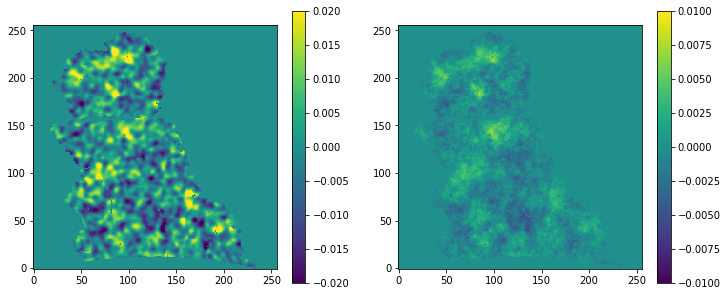

In [12]:
_ = plt.figure(figsize =(12,5))
_ = plt.subplot(1,2,1)
_ = plt.imshow(ks_smoothed*sv_mask, origin='lower', clim = (-0.02,0.02)), plt.colorbar()
_ = plt.subplot(1,2,2)
_ = plt.imshow(wiener_map_sv*sv_mask, origin='lower', clim = (-0.01,0.01)), plt.colorbar()

# Apply model

In [13]:
test_output_rescaled = apply_deepmass(wiener.filtering(e1_map, e2_map, power_map, Ncov, 30)[0],
                                      model)
test_output_rescaled = ndimage.gaussian_filter(test_output_rescaled, sigma=0.5)


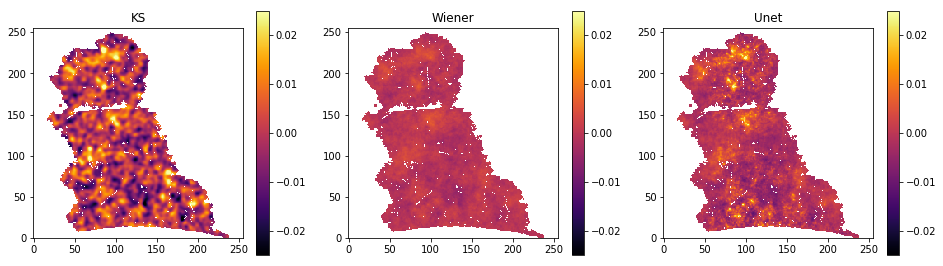

In [14]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('KS')
_ = plt.imshow(np.where(sv_mask!=0.,ks_smoothed,np.nan), origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener')
_ = plt.imshow(np.where(sv_mask!=0.,wiener_map_sv,np.nan), origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Unet')
_ = plt.imshow(np.where(sv_mask!=0.,test_output_rescaled,np.nan), origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


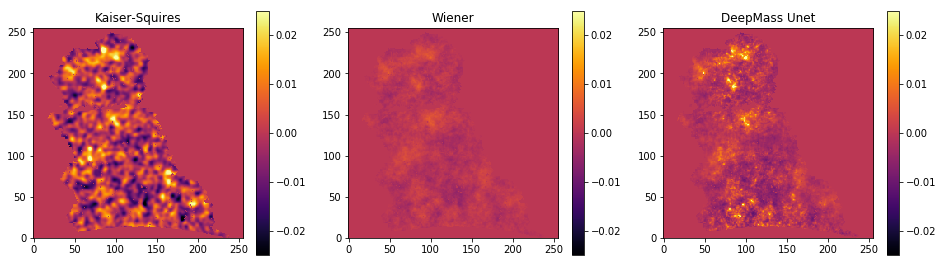

In [15]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Kaiser-Squires')
_ = plt.imshow(sv_mask*ks_smoothed, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener')
_ = plt.imshow(sv_mask*wiener_map_sv, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('DeepMass Unet')
_ = plt.imshow(sv_mask*test_output_rescaled, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
plt.savefig('DES_SV_deepmass.pdf')

# Apply to Mice

In [16]:
e1_mice_map = -np.load('../mice_mock/sv_patches/e1_noisy_030419_0.npy')
e2_mice_map = -np.load('../mice_mock/sv_patches/e2_noisy_030419_0.npy')
kappa_mice_map = np.load('../mice_mock/sv_patches/kappa_true_030419_0.npy')

In [17]:
ks_mice = ld.ks(e1_mice_map + 1j*e2_mice_map).real
ks_mice_smoothed = ndimage.gaussian_filter(ks_mice, sigma=10./4.5)
wiener_mice_sv_mice_power, _  = wiener.filtering(e1_mice_map, e2_mice_map, mice_power_map, Ncov, 30)
wiener_mice_sv, _  = wiener.filtering(e1_mice_map, e2_mice_map, power_map, Ncov, 30)
wiener_mice_sv_mice_power = ndimage.gaussian_filter(wiener_mice_sv_mice_power, sigma=0.5)

mice_output_rescaled = apply_deepmass(wiener_mice_sv, model)
mice_output_rescaled = ndimage.gaussian_filter(mice_output_rescaled, sigma=0.5)

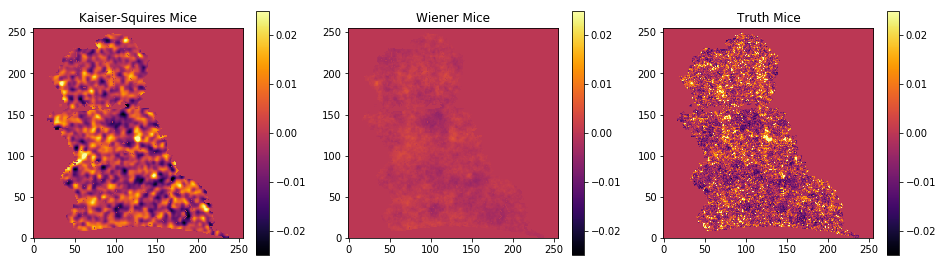

In [18]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Kaiser-Squires Mice')
_ = plt.imshow(sv_mask*ks_mice_smoothed, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener Mice')
_ = plt.imshow(sv_mask*wiener_mice_sv_mice_power, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Truth Mice')
_ = plt.imshow(sv_mask*kappa_mice_map, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


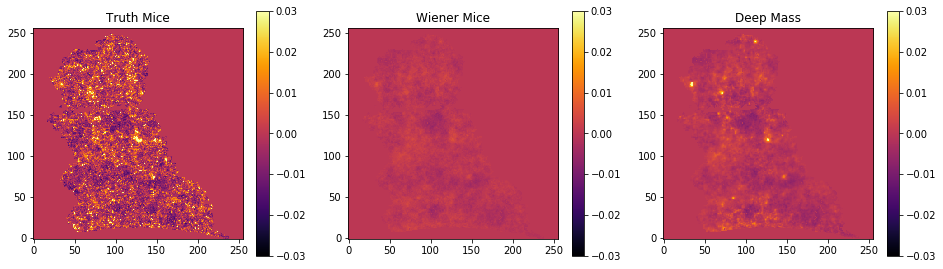

In [19]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Truth Mice')
_ = plt.imshow(sv_mask*kappa_mice_map, origin='lower',
               cmap='inferno', clim = (-0.03,0.03)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener Mice')
_ = plt.imshow(sv_mask*wiener_mice_sv, origin='lower',
               cmap='inferno',  clim = (-0.03,0.03)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Deep Mass')
_ = plt.imshow(sv_mask*mice_output_rescaled, origin='lower',
               cmap='inferno',  clim = (-0.03,0.03)), plt.colorbar()


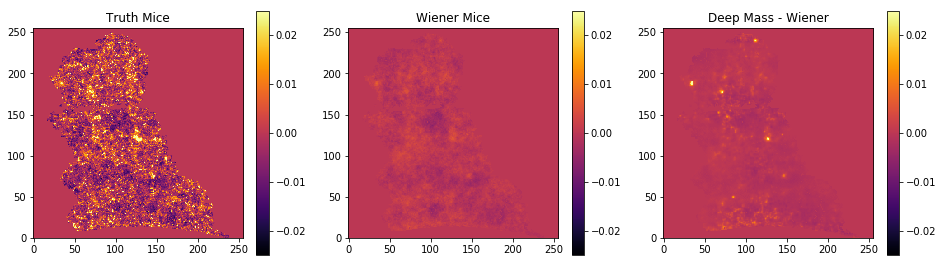

In [20]:
_ = plt.figure(figsize =(16,4.5))
_ = plt.subplot(1,3,1), plt.title('Truth Mice')
_ = plt.imshow(sv_mask*kappa_mice_map, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener Mice')
_ = plt.imshow(sv_mask*wiener_mice_sv, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Deep Mass - Wiener')
_ = plt.imshow(sv_mask*mice_output_rescaled-sv_mask*wiener_mice_sv, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()


# Stats

In [21]:
def flatten_mask(map_array, mask):
    map_array = map_array.flatten()
    return map_array[np.where(mask.flatten()>0.5)]

In [22]:
flattened_masked_truth = flatten_mask(kappa_mice_map, sv_mask)
flattened_masked_ks = flatten_mask(ks_mice_smoothed, sv_mask)
flattened_masked_wiener = flatten_mask(wiener_mice_sv_mice_power, sv_mask)
flattened_masked_deepmass = flatten_mask(mice_output_rescaled, sv_mask)

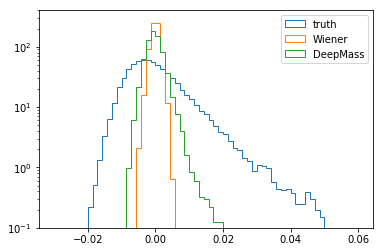

In [23]:
_ = plt.hist(flattened_masked_truth, np.linspace(-0.03,0.06,64), histtype='step', label='truth', density=True)
_ = plt.hist(flattened_masked_wiener, np.linspace(-0.03,0.06,64), histtype='step', label='Wiener', density=True)
_ = plt.hist(flattened_masked_deepmass, np.linspace(-0.03,0.06,64), histtype='step',
             label='DeepMass', density=True)
plt.yscale('log')
plt.ylim(0.1,400)
_ = plt.legend()

In [24]:
print('MSE KS: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_ks)))
print('MSE Wiener: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_wiener)))
print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_deepmass)))

MSE KS: 0.00010224475434578727
MSE Wiener: 7.433667354453335e-05
MSE DeepMass: 7.131591298408481e-05


In [25]:
print('MSE KS: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_ks)))
print('MSE Wiener: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_wiener)))
print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_masked_truth, flattened_masked_deepmass)))

MSE KS: 0.00010224475434578727
MSE Wiener: 7.433667354453335e-05
MSE DeepMass: 7.131591298408481e-05


In [26]:
print('Pearson KS: ' + str(pearsonr(flattened_masked_truth, flattened_masked_ks)))
print('Pearson Wiener: ' + str(pearsonr(flattened_masked_truth, flattened_masked_wiener)))
print('Pearson DeepMass: ' + str(pearsonr(flattened_masked_truth, flattened_masked_deepmass)))

Pearson KS: (0.2716025267403879, 0.0)
Pearson Wiener: (0.31483976841821393, 0.0)
Pearson DeepMass: (0.336371486750208, 0.0)


In [27]:
print(np.median(np.absolute(flattened_masked_truth -flattened_masked_ks )))
print(np.median(np.absolute(flattened_masked_truth -flattened_masked_wiener )))
print(np.median(np.absolute(flattened_masked_truth -flattened_masked_deepmass )))

0.006070460866218106
0.004763716375362577
0.0046712635121366475


In [28]:
print(np.mean(np.absolute(flattened_masked_truth -flattened_masked_ks )))
print(np.mean(np.absolute(flattened_masked_truth -flattened_masked_wiener )))
print(np.mean(np.absolute(flattened_masked_truth -flattened_masked_deepmass )))

0.007631427136232882
0.006110471545514479
0.006013546209975932


In [29]:
np.log((flattened_masked_truth*3+0.5) / (flattened_masked_ks*3+0.5))

array([ 0.08403367,  0.08618932,  0.01981236, ...,  0.05146075,
       -0.01948495, -0.04748367])

In [30]:
np.sum((flattened_masked_truth*3+0.5)  * np.log((flattened_masked_truth*3+0.5) / (flattened_masked_ks*3+0.5)))


46.33776518725543

In [31]:
np.sum((flattened_masked_truth*3+0.5)  * np.log((flattened_masked_truth*3+0.5) / (flattened_masked_wiener*3+0.5)))


39.00613481424746

In [32]:
np.sum((flattened_masked_truth*3+0.5)  * np.log((flattened_masked_truth*3+0.5) / (flattened_masked_deepmass*3+0.5)))


50.445416396186936

# Loop over all Mice

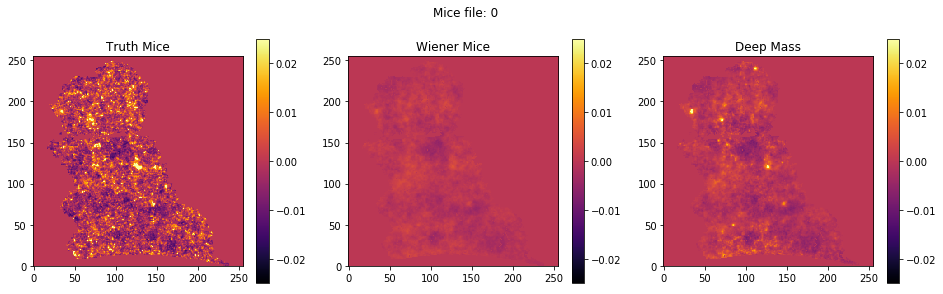

MSE KS: 8.170480353820904e-05
MSE Wiener: 4.52092643544487e-05
MSE DeepMass: 4.2636989992098156e-05
0.00731365935065794 0.007126224489937576
MSE KS: 0.00042300178896783827
MSE Wiener: 0.0004999387857366862
MSE DeepMass: 0.0004265822917825153
Pearson KS: (0.23108057610806673, 0.0)
Pearson Wiener: (0.3818636736930573, 0.0)
Pearson DeepMass: (0.4044631738683832, 0.0)
Reduced: 23.389947971999725, 5.520667855475954
variance ratio: 0.03806091158859037, 0.15208133625003162
MAE (median): 0.003811621078653439, 0.0037134486342796226


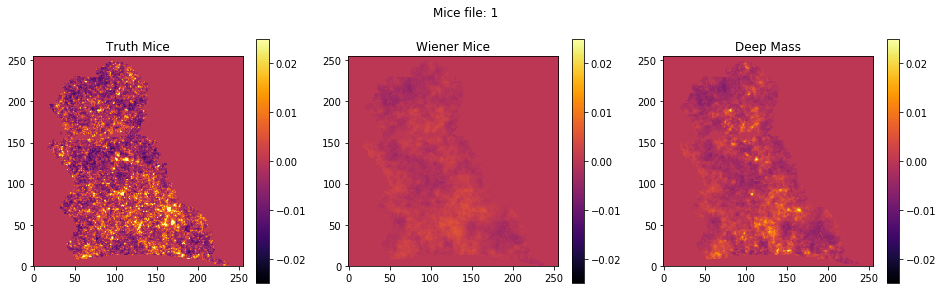

MSE KS: 8.5586716415097e-05
MSE Wiener: 4.54772471172405e-05
MSE DeepMass: 4.4036671369571776e-05
0.006639807064682165 0.007146068140641138
MSE KS: 0.000438442596554754
MSE Wiener: 0.00045425292666617737
MSE DeepMass: 0.0003929660033255331
Pearson KS: (0.1526138143539509, 1.092431050180775e-146)
Pearson Wiener: (0.36077721174528554, 0.0)
Pearson DeepMass: (0.3767090352084416, 0.0)
Reduced: 16.75866834041175, 4.686730871142635
variance ratio: 0.05313985380190973, 0.18399675450411038
MAE (median): 0.0041144127226050015, 0.003966261419138707


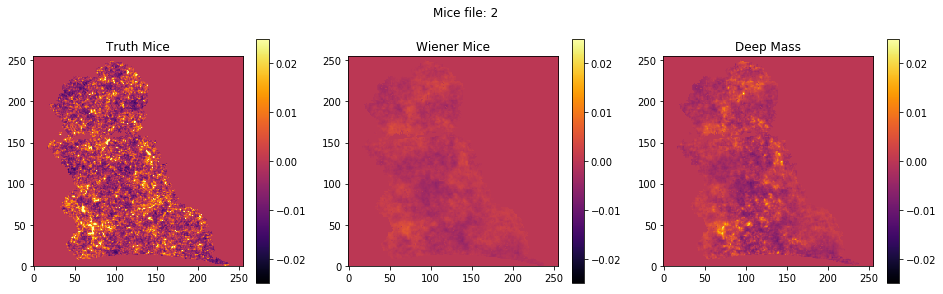

MSE KS: 9.512937328818303e-05
MSE Wiener: 4.679771903282746e-05
MSE DeepMass: 4.5883260948698394e-05
0.007353975421102033 0.007223604575190024
MSE KS: 0.000468565465935105
MSE Wiener: 0.0005080231159630735
MSE DeepMass: 0.00045180502653038125
Pearson KS: (0.1454078431813101, 3.326943998198986e-133)
Pearson Wiener: (0.3515210259907325, 0.0)
Pearson DeepMass: (0.36172878265644837, 0.0)
Reduced: 19.05888183290946, 5.11142623811998
variance ratio: 0.04705646940947952, 0.17203002367992515
MAE (median): 0.0038937734508875804, 0.003871945687755913


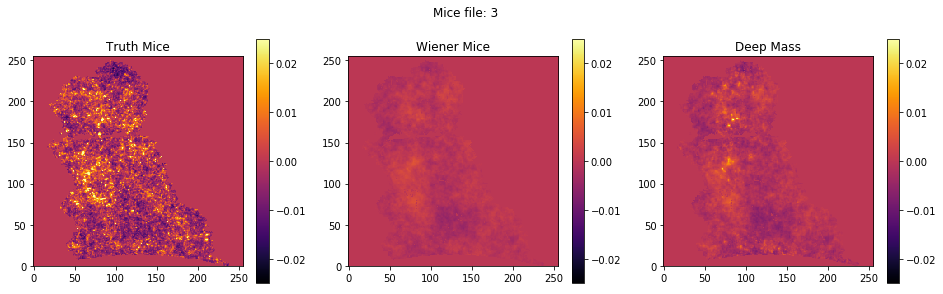

MSE KS: 7.831278820807141e-05
MSE Wiener: 4.2690275608283916e-05
MSE DeepMass: 4.162758484599303e-05
0.006292181067013742 0.006923054847238249
MSE KS: 0.00040664171982063556
MSE Wiener: 0.0004009958787342296
MSE DeepMass: 0.00038598782528222414
Pearson KS: (0.14663762213818138, 1.857673860981606e-135)
Pearson Wiener: (0.36565188132055465, 0.0)
Pearson DeepMass: (0.36365432840011597, 0.0)
Reduced: 19.116951880608784, 7.532150659491078
variance ratio: 0.04659236623731787, 0.11530992026645123
MAE (median): 0.004003962638096392, 0.0038275106951212758


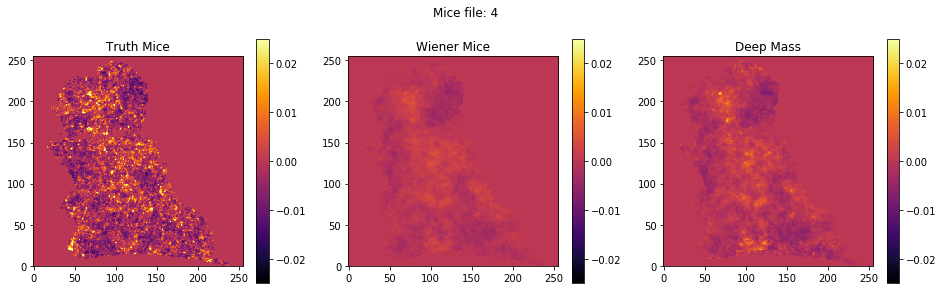

MSE KS: 8.041861408161523e-05
MSE Wiener: 4.022416061942113e-05
MSE DeepMass: 3.9539116733036407e-05
0.005503739373355552 0.006625921890278502
MSE KS: 0.0004219774351278756
MSE Wiener: 0.0003612671770110434
MSE DeepMass: 0.0003517372345637174
Pearson KS: (0.13121206005420408, 1.280212062852327e-108)
Pearson Wiener: (0.3484580774281906, 0.0)
Pearson DeepMass: (0.3372103538343058, 0.0)
Reduced: 15.50843104137088, 6.572684749850931
variance ratio: 0.05907809775881322, 0.137022389608436
MAE (median): 0.004038035004615104, 0.003888771274452651


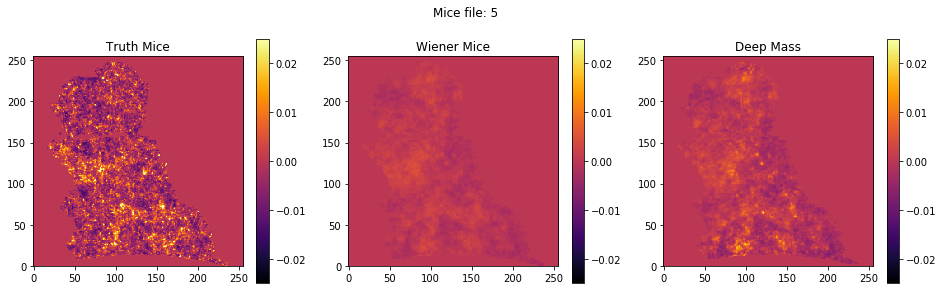

MSE KS: 8.166305533603134e-05
MSE Wiener: 4.143945574587122e-05
MSE DeepMass: 4.1534263807719036e-05
0.005879096619882151 0.006610981452821844
MSE KS: 0.00034268783082892616
MSE Wiener: 0.0003678819015116679
MSE DeepMass: 0.0003371223423659492
Pearson KS: (0.15009217934204686, 6.825654780457627e-142)
Pearson Wiener: (0.2853777802670939, 0.0)
Pearson DeepMass: (0.28724888560824496, 0.0)
Reduced: 19.692891078135364, 5.805510947696769
variance ratio: 0.04814738300917356, 0.16369453899294145
MAE (median): 0.004088608267345282, 0.00404836206253026


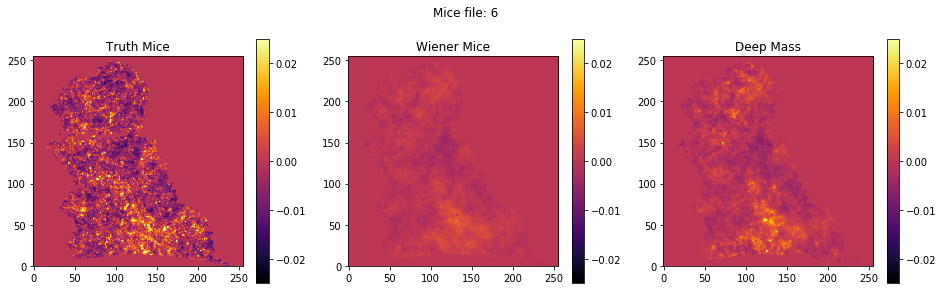

MSE KS: 8.602249064743373e-05
MSE Wiener: 4.1480453043965376e-05
MSE DeepMass: 4.0705333833306604e-05
0.0053871133988321355 0.0066865405743675565
MSE KS: 0.0003412990935059189
MSE Wiener: 0.0003249230454485819
MSE DeepMass: 0.0002972980133612766
Pearson KS: (0.1331044548969605, 9.563020164578116e-112)
Pearson Wiener: (0.39329173708897835, 0.0)
Pearson DeepMass: (0.38016317794099314, 0.0)
Reduced: 15.23113184370007, 4.955062528644117
variance ratio: 0.060912769380090465, 0.18373809657032347
MAE (median): 0.00426283350790946, 0.00411842542177435


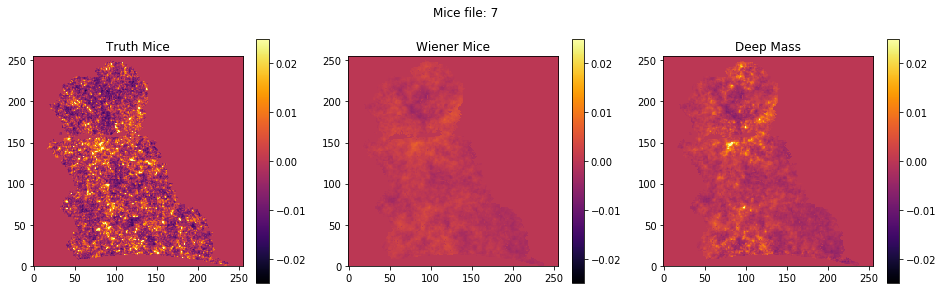

MSE KS: 8.522899097553077e-05
MSE Wiener: 4.467338425995888e-05
MSE DeepMass: 4.4594737382243746e-05
0.006164177210151824 0.006955438045889261
MSE KS: 0.0003561039378390342
MSE Wiener: 0.0003912041365785469
MSE DeepMass: 0.0003521296351234303
Pearson KS: (0.16361524713727946, 1.36750378173894e-168)
Pearson Wiener: (0.3501260912455702, 0.0)
Pearson DeepMass: (0.3413918193829702, 0.0)
Reduced: 18.42656098350132, 4.691578444973812
variance ratio: 0.0501135988237733, 0.19647878111525774
MAE (median): 0.004318961059171254, 0.0042097941021801795


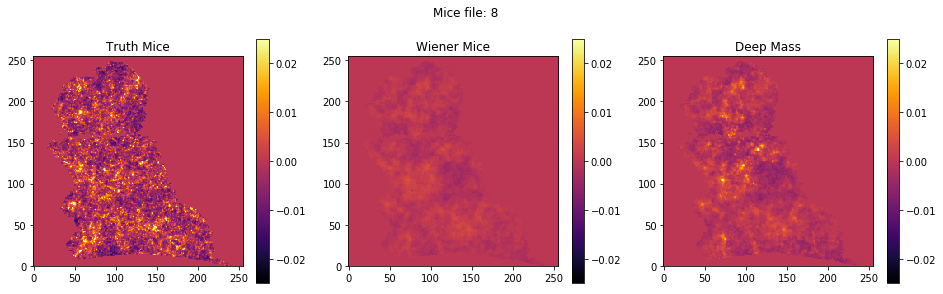

MSE KS: 8.313360744554426e-05
MSE Wiener: 4.120588150921894e-05
MSE DeepMass: 4.078434410158693e-05
0.005894257936391914 0.006712702407090277
MSE KS: 0.0003742483379716159
MSE Wiener: 0.0003711255336596181
MSE DeepMass: 0.00034499921798590913
Pearson KS: (0.15424161079971296, 7.911279015688483e-150)
Pearson Wiener: (0.3412868896685405, 0.0)
Pearson DeepMass: (0.3285402222545686, 0.0)
Reduced: 21.087520801056236, 5.420379334769732
variance ratio: 0.043364954706543314, 0.1669817519206861
MAE (median): 0.004098626246050803, 0.003977009271241463


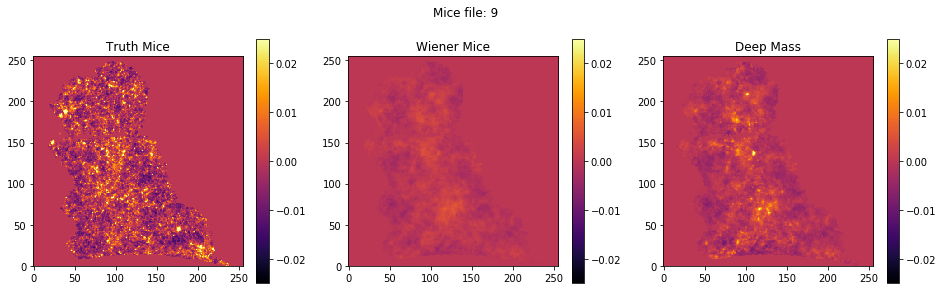

MSE KS: 8.507199797783013e-05
MSE Wiener: 4.355814332276383e-05
MSE DeepMass: 4.3538601437353495e-05
0.006807049643468863 0.006914145933505494
MSE KS: 0.0004542136551046995
MSE Wiener: 0.00044326209755343157
MSE DeepMass: 0.00040905317096065247
Pearson KS: (0.12775392641697103, 5.032426820570662e-103)
Pearson Wiener: (0.31267816215428607, 0.0)
Pearson DeepMass: (0.3163118572746045, 0.0)
Reduced: 18.597717560621984, 5.165087529962587
variance ratio: 0.04899284146222699, 0.17632735998543547
MAE (median): 0.003929986453303962, 0.0038554065006921974


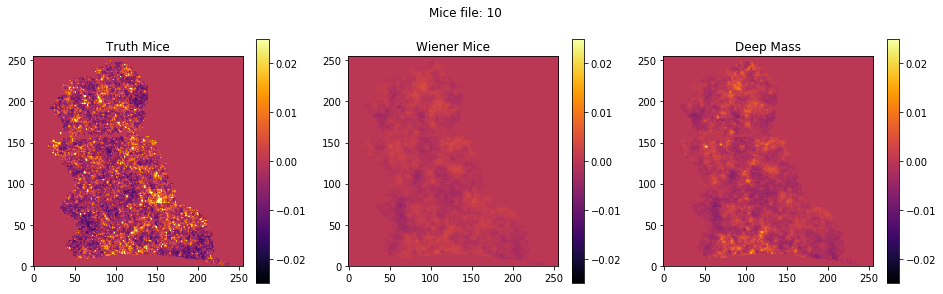

MSE KS: 8.310584429962349e-05
MSE Wiener: 4.061041036938742e-05
MSE DeepMass: 4.0444879188335843e-05
0.0058496867445500585 0.0066831184607239556
MSE KS: 0.00038086301831685975
MSE Wiener: 0.0003804160409899733
MSE DeepMass: 0.00036580378111732923
Pearson KS: (0.12091630979034523, 2.0493818300657395e-92)
Pearson Wiener: (0.35739088504360556, 0.0)
Pearson DeepMass: (0.3179523959047362, 0.0)
Reduced: 23.065850135321867, 7.131486040331302
variance ratio: 0.03941936224316558, 0.1269770367056538
MAE (median): 0.003980961927176278, 0.003909296371109466


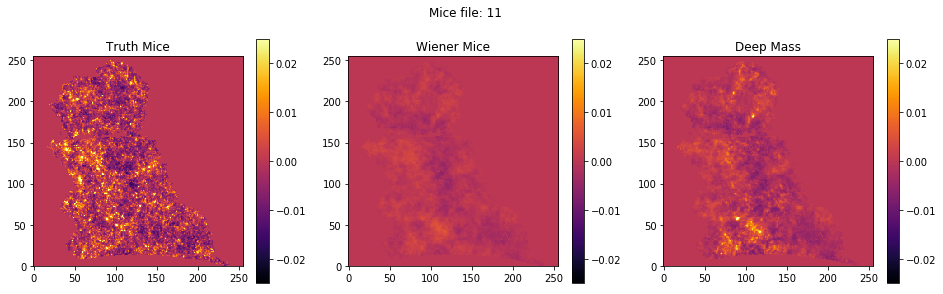

MSE KS: 8.181546903261074e-05
MSE Wiener: 4.205390814351515e-05
MSE DeepMass: 4.1786228946661437e-05
0.006606717612986414 0.006911933330708958
MSE KS: 0.0003918232546014976
MSE Wiener: 0.0004084537596950684
MSE DeepMass: 0.0003689773078153352
Pearson KS: (0.20219951031971553, 3.130156929206599e-258)
Pearson Wiener: (0.38584382148815977, 0.0)
Pearson DeepMass: (0.36486313217897487, 0.0)
Reduced: 18.482205442761497, 4.269515145393809
variance ratio: 0.04762702861898399, 0.20485923186941385
MAE (median): 0.003931983039355332, 0.0038517596263722177


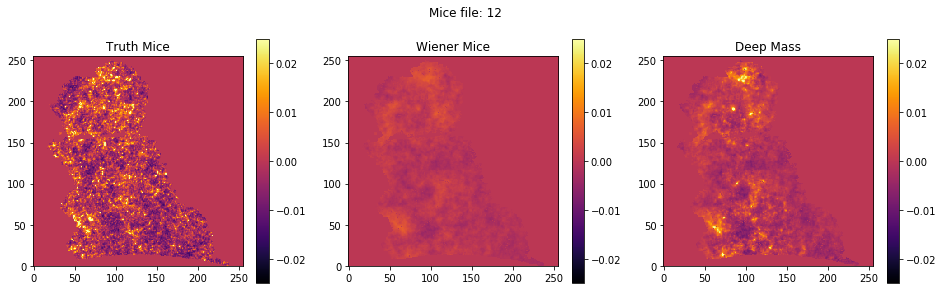

MSE KS: 8.82672912963707e-05
MSE Wiener: 4.3180367971057694e-05
MSE DeepMass: 4.231816107179899e-05
0.007115334182617707 0.0071382250284916515
MSE KS: 0.00042417436734977
MSE Wiener: 0.0004204899857546935
MSE DeepMass: 0.00035268247860027345
Pearson KS: (0.18134106170710115, 2.8739678970868462e-207)
Pearson Wiener: (0.4383910849222513, 0.0)
Pearson DeepMass: (0.4246911081551251, 0.0)
Reduced: 14.27788695804459, 3.0167194193795983
variance ratio: 0.05935289818702183, 0.2753032883494008
MAE (median): 0.003981093731929368, 0.0038705537501288407


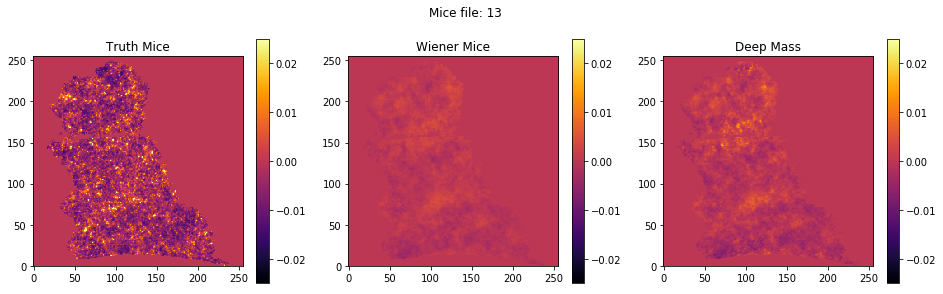

MSE KS: 8.689472516861088e-05
MSE Wiener: 4.1908158907410463e-05
MSE DeepMass: 4.076876975584856e-05
0.003599793039506568 0.006106635148650237
MSE KS: 0.00028490350299086015
MSE Wiener: 0.0002584178825962039
MSE DeepMass: 0.00025014781180324864
Pearson KS: (0.1195637390738837, 2.185225390078295e-90)
Pearson Wiener: (0.2811622189999507, 0.0)
Pearson DeepMass: (0.2797187197061151, 0.0)
Reduced: 21.259344626270444, 8.040849246227031
variance ratio: 0.052862142810323004, 0.13596331357755528
MAE (median): 0.00467465348150488, 0.004453255812313681


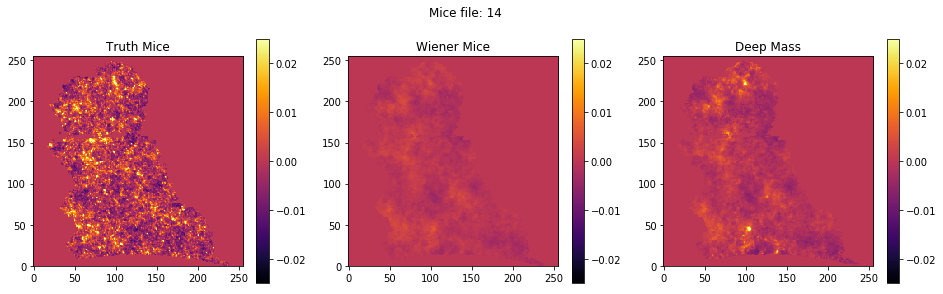

MSE KS: 8.746639189701604e-05
MSE Wiener: 4.420714215495657e-05
MSE DeepMass: 4.314931905934462e-05
0.007465205399295236 0.007070470568291777
MSE KS: 0.0004734380912306203
MSE Wiener: 0.0004621472122283436
MSE DeepMass: 0.0004264201066516407
Pearson KS: (0.12341343721307797, 3.208443928651259e-96)
Pearson Wiener: (0.3868257362163469, 0.0)
Pearson DeepMass: (0.37987209110774733, 0.0)
Reduced: 19.90670192687153, 5.7151504025111715
variance ratio: 0.044421834414327906, 0.15102527837416396
MAE (median): 0.00380373988160993, 0.003707946117885001


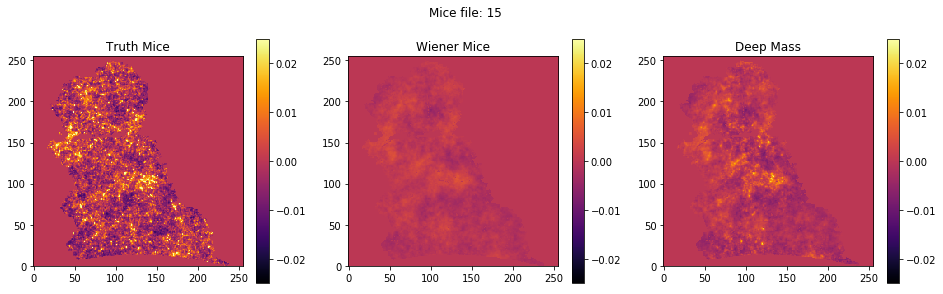

MSE KS: 9.111034972954352e-05
MSE Wiener: 4.56022286123262e-05
MSE DeepMass: 4.390053562824623e-05
0.007341269165128696 0.007228827483639043
MSE KS: 0.00046784443096531137
MSE Wiener: 0.0004546823236820332
MSE DeepMass: 0.00040939495376855225
Pearson KS: (0.1544794102429185, 2.7327304519794276e-150)
Pearson Wiener: (0.40126420368662064, 0.0)
Pearson DeepMass: (0.4021062915897176, 0.0)
Reduced: 18.395092309774714, 5.0965521052553475
variance ratio: 0.047440403595411046, 0.16483811124327938
MAE (median): 0.0039438597585404285, 0.003854416527243766


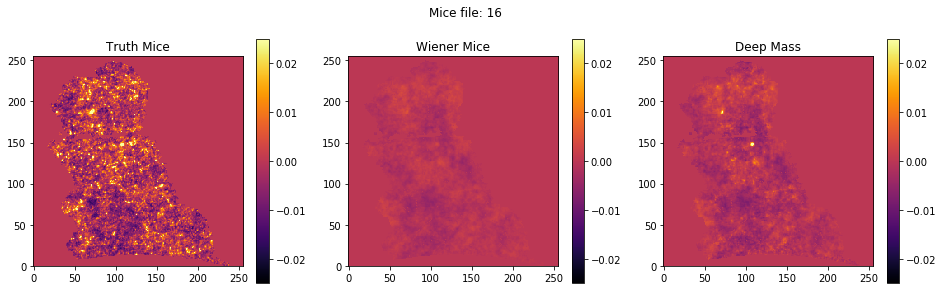

MSE KS: 8.794632334624414e-05
MSE Wiener: 4.706288796708858e-05
MSE DeepMass: 4.540493703436027e-05
0.007008450209033935 0.007223763696112789
MSE KS: 0.0004797898930148302
MSE Wiener: 0.0005177482475891225
MSE DeepMass: 0.0004698565660497616
Pearson KS: (0.16345188331091667, 2.970794729781476e-168)
Pearson Wiener: (0.3496732360441285, 0.0)
Pearson DeepMass: (0.37320797071335826, 0.0)
Reduced: 22.93146380574993, 7.276178283265684
variance ratio: 0.039329618485408016, 0.11958389207814353
MAE (median): 0.003919881271960232, 0.0037854932625649056


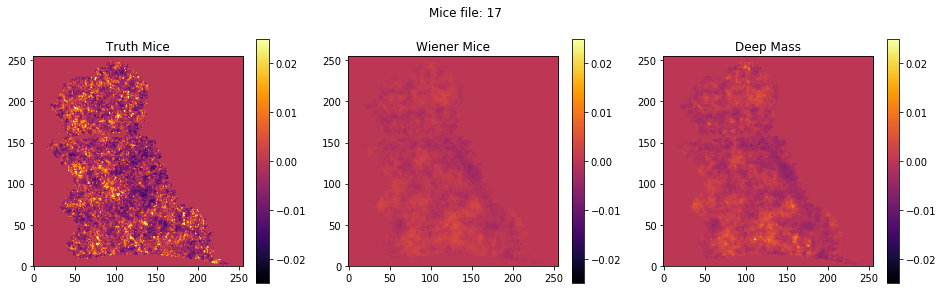

MSE KS: 8.542020378465558e-05
MSE Wiener: 4.014745029086197e-05
MSE DeepMass: 3.982935361717909e-05
0.005125960887450272 0.006365362119542636
MSE KS: 0.00033045154341283973
MSE Wiener: 0.00030116786826156673
MSE DeepMass: 0.00029663100633804847
Pearson KS: (0.07036352218268124, 2.528540008740153e-32)
Pearson Wiener: (0.22056294663244497, 4.373960985332572e-308)
Pearson DeepMass: (0.2351922274062666, 0.0)
Reduced: 21.666990419714537, 8.551498090417494
variance ratio: 0.045731257873041165, 0.114951548161668
MAE (median): 0.004212224773238564, 0.004134270655995214


In [33]:
wiener_mse = []
ks_mse = []
deepmass_mse = []
wiener_mse_high = []
ks_mse_high = []
deepmass_mse_high = []
wiener_pearson = []
deepmass_pearson = []
wiener_reduced = []
deepmass_reduced = []
wiener_var_ratio= []
deepmass_var_ratio = []
wiener_mae= []
deepmass_mae = []

for i in range(18):
    
    e1_mice_map_temp = -np.load('../mice_mock/sv_patches/e1_noisy_030419_'+str(i)+'.npy')
    e2_mice_map_temp = -np.load('../mice_mock/sv_patches/e2_noisy_030419_'+str(i)+'.npy')
    kappa_mice_map_temp = np.load('../mice_mock/sv_patches/kappa_true_030419_'+str(i)+'.npy')
    ks_mice_temp = ld.ks(e1_mice_map_temp + 1j*e1_mice_map_temp).real
    ks_mice_smoothed_temp = ndimage.gaussian_filter(ks_mice_temp, sigma=10./4.5)
    wiener_mice_sv_mice_power_temp, _  = wiener.filtering(e1_mice_map_temp, e2_mice_map_temp, mice_power_map, Ncov, 30)
#     wiener_mice_sv_temp, _  = wiener.filtering(e1_mice_map_temp, e2_mice_map_temp, power_map, Ncov, 30)
    mice_output_rescaled_temp = \
    apply_deepmass(wiener.filtering(e1_mice_map_temp, e2_mice_map_temp, power_map, Ncov, 30)[0],
                                               model)
    
    kappa_mice_map_temp = ndimage.gaussian_filter(kappa_mice_map_temp, sigma=0.5)
    wiener_mice_sv_mice_power_temp = ndimage.gaussian_filter(wiener_mice_sv_mice_power_temp, sigma=0.5)
    mice_output_rescaled_temp = ndimage.gaussian_filter(mice_output_rescaled_temp, sigma=0.5)
    
    
    _ = plt.figure(figsize =(16,4.5)), plt.suptitle('Mice file: '+str(i))
    _ = plt.subplot(1,3,1), plt.title('Truth Mice')
    _ = plt.imshow(sv_mask*kappa_mice_map_temp, origin='lower',
                   cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
    _ = plt.subplot(1,3,2), plt.title('Wiener Mice')
    _ = plt.imshow(sv_mask*wiener_mice_sv_mice_power_temp, origin='lower',
                   cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
    _ = plt.subplot(1,3,3), plt.title('Deep Mass')
    _ = plt.imshow(sv_mask*mice_output_rescaled_temp, origin='lower',
                   cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
    _ =plt.show()
    
    flattened_truth_temp = flatten_mask(kappa_mice_map_temp, sv_mask)
    flattened_ks_temp = flatten_mask(ks_mice_smoothed_temp, sv_mask)
    flattened_wiener_temp = flatten_mask(wiener_mice_sv_mice_power_temp, sv_mask)
    flattened_deepmass_temp = flatten_mask(mice_output_rescaled_temp, sv_mask)
    

    print('MSE KS: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_ks_temp)))
    print('MSE Wiener: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_wiener_temp)))
    print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_deepmass_temp)))
    
    ks_mse.append(mf.mean_square_error(flattened_truth_temp, flattened_ks_temp))
    wiener_mse.append(mf.mean_square_error(flattened_truth_temp, flattened_wiener_temp))
    deepmass_mse.append(mf.mean_square_error(flattened_truth_temp, flattened_deepmass_temp))
    
    where_truth_big = np.where(flattened_truth_temp>2.0*np.std(flattened_truth_temp)+np.mean(flattened_truth_temp))
    print(np.std(flattened_truth_temp)+np.mean(flattened_truth_temp), np.std(flattened_truth_temp))
    
    print('MSE KS: ' + str(mf.mean_square_error(flattened_truth_temp[where_truth_big],
                                                flattened_ks_temp[where_truth_big])))
    print('MSE Wiener: ' + str(mf.mean_square_error(flattened_truth_temp[where_truth_big],
                                                    flattened_wiener_temp[where_truth_big])))
    print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_truth_temp[where_truth_big],
                                                      flattened_deepmass_temp[where_truth_big])))
    
    ks_mse_high.append(mf.mean_square_error(flattened_truth_temp[where_truth_big],
                                       flattened_ks_temp[where_truth_big]))
    wiener_mse_high.append(mf.mean_square_error(flattened_truth_temp[where_truth_big],
                                           flattened_wiener_temp[where_truth_big]))
    deepmass_mse_high.append(mf.mean_square_error(flattened_truth_temp[where_truth_big],
                                             flattened_deepmass_temp[where_truth_big]))
    
    print('Pearson KS: ' + str(pearsonr(flattened_truth_temp, flattened_ks_temp)))
    print('Pearson Wiener: ' + str(pearsonr(flattened_truth_temp, flattened_wiener_temp)))
    print('Pearson DeepMass: ' + str(pearsonr(flattened_truth_temp, flattened_deepmass_temp)))

    wiener_pearson.append(pearsonr(flattened_truth_temp, flattened_wiener_temp)[0])
    deepmass_pearson.append(pearsonr(flattened_truth_temp, flattened_deepmass_temp)[0])
    
    
    wiener_reduced.append(mf.mean_square_error(flattened_truth_temp,
                                               flattened_wiener_temp)/np.var(flattened_wiener_temp))
    
    deepmass_reduced.append(mf.mean_square_error(flattened_truth_temp,
                                               flattened_deepmass_temp)/np.var(flattened_deepmass_temp))
    
    print('Reduced: ' + str(wiener_reduced[-1])+', ' + str(deepmass_reduced[-1]))
    
    
    wiener_var_ratio.append(np.var(flattened_wiener_temp)/np.var(flattened_truth_temp))
    deepmass_var_ratio.append(np.var(flattened_deepmass_temp)/np.var(flattened_truth_temp))
    print('variance ratio: ' + str(wiener_var_ratio[-1])+', ' + str(deepmass_var_ratio[-1]))
    
    
    wiener_mae.append(np.median(np.absolute(flattened_truth_temp - flattened_wiener_temp)))
    deepmass_mae.append(np.median(np.absolute(flattened_truth_temp - flattened_deepmass_temp)))
    print('MAE (median): ' + str(wiener_mae[-1])+', ' + str(deepmass_mae[-1]))


In [34]:
print(np.mean(np.array(wiener_mse)), np.std(np.array(wiener_mse), ddof=1))
print(np.mean(np.array(deepmass_mse)), np.std(np.array(deepmass_mse), ddof=1))

4.319602994614467e-05 2.2272043936518293e-06
4.2360171597410144e-05 1.8986603431967013e-06


In [35]:
print(np.mean(np.array(wiener_mse_high)), np.std(np.array(wiener_mse_high), ddof=1))
print(np.mean(np.array(deepmass_mse_high)), np.std(np.array(deepmass_mse_high), ddof=1))

0.0004070221066477812 7.115427160144368e-05
0.0003716441540792099 5.665697931789976e-05


In [36]:
print(((np.array(deepmass_mse))/(np.array(wiener_mse)) - 1.)*100.)

[-5.6897063  -3.16768459 -1.9540655  -2.48930406 -1.70306571  0.22878694
 -1.86863728 -0.17604862 -1.02300301 -0.04486391 -0.40760775 -0.63651444
 -1.99675672 -2.71877644 -2.39287826 -3.73160049 -3.52284147 -0.79232099]


In [37]:
print(((np.array(deepmass_mse_high))/(np.array(wiener_mse_high)) - 1.)*100.)

[-14.6730952  -13.49180594 -11.06604949  -3.74269519  -2.63792092
  -8.36125915  -8.50202301  -9.98826388  -7.03975159  -7.7175393
  -3.84112611  -9.66485213 -16.12583164  -3.20027032  -7.73067642
  -9.96022224  -9.24999394  -1.50642296]


In [38]:
print(np.mean((np.array(deepmass_mse))/(np.array(wiener_mse)) - 1.)*100.)

-1.8937160330132208


In [39]:
print(np.mean((np.array(deepmass_mse_high))/(np.array(wiener_mse_high)) - 1.)*100.)

-8.249988856796614


In [40]:
print(np.mean((np.array(deepmass_mse))/(np.array(ks_mse)) - 1.)*100.)
print(np.std((np.array(deepmass_mse))/(np.array(ks_mse)) - 1.)*100.)

-50.26081894430512
1.9644437369889765


In [41]:
print(np.mean((np.array(wiener_mse))/(np.array(ks_mse)) - 1.)*100.)
print(np.std((np.array(wiener_mse))/(np.array(ks_mse)) - 1.)*100.)

-49.2853788068664
2.2419013539202526


In [42]:
print(np.mean(np.array(wiener_mse)), np.std(np.array(wiener_mse), ddof=1))
print(np.mean(np.array(deepmass_mse)), np.std(np.array(deepmass_mse), ddof=1))

4.319602994614467e-05 2.2272043936518293e-06
4.2360171597410144e-05 1.8986603431967013e-06


In [43]:
6.954766068644303e-05/7.022635513031861e-05 - 1.

-0.009664383729101944

In [44]:
print(np.mean(np.array(wiener_pearson)), np.std(np.array(wiener_pearson), ddof=1))
print(np.mean(np.array(deepmass_pearson)), np.std(np.array(deepmass_pearson), ddof=1))

0.35067481464643324 0.05059714996046677
0.34861253184395097 0.04835079888964702


In [45]:
print(np.mean(np.array(wiener_reduced)), np.std(np.array(wiener_reduced), ddof=1))
print(np.mean(np.array(deepmass_reduced)), np.std(np.array(deepmass_reduced), ddof=1))

19.269679942156927 2.686422241532006
5.808845994050502 1.4351154662770358


In [46]:
print(np.mean(np.array(wiener_var_ratio)), np.std(np.array(wiener_var_ratio), ddof=1))
print(np.mean(np.array(deepmass_var_ratio)), np.std(np.array(deepmass_var_ratio), ddof=1))

0.0484246551336445 0.0066905809644516616
0.1633979251807154 0.03915733693506343


In [47]:
print(np.mean(np.array(wiener_mae)), np.std(np.array(wiener_mae), ddof=1))
print(np.mean(np.array(deepmass_mae)), np.std(np.array(deepmass_mae), ddof=1))

0.004056067682997405 0.00021027552203302046
0.0039468848440433165 0.0001871983051473775


In [48]:
np.mean(np.array(deepmass_mae))/np.mean(np.array(wiener_mae)) -1.

-0.026918396705205683

# Test on a non-fiducal picola 

In [52]:
picola_true04 = np.load('../picola_training/nicaea_rescaled_nongauss_noise/training_data04/sv_training_kappa_true.npy')[0,:,:,0]
gc.collect()



21960

In [53]:
picola_wiener04 = np.load('../picola_training/nicaea_rescaled_nongauss_noise/training_data04/sv_training_wiener.npy')[0,:,:,0]
gc.collect()


picola_wiener04 = ndimage.gaussian_filter(picola_wiener04, sigma=0.5)


In [54]:
picola_true54 = np.load('../picola_training/nicaea_rescaled_nongauss_noise/training_data54/sv_training_kappa_true.npy')[0,:,:,0]
gc.collect()


3

In [55]:
picola_wiener54 = np.load('../picola_training/nicaea_rescaled_nongauss_noise/training_data54/sv_training_wiener.npy')[0,:,:,0]
gc.collect()

picola_wiener54 = ndimage.gaussian_filter(picola_wiener54, sigma=0.5)

In [56]:
picola_deepmass04 = apply_deepmass(picola_wiener04, model)
picola_deepmass54 = apply_deepmass(picola_wiener54, model)


picola_deepmass04 = ndimage.gaussian_filter(picola_deepmass04, sigma=0.5)
picola_deepmass54 = ndimage.gaussian_filter(picola_deepmass54, sigma=0.5)


In [57]:
picola_true04.shape

(256, 256)

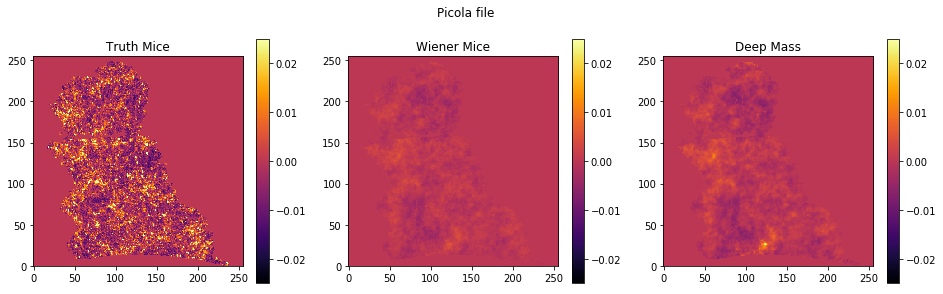

In [58]:
_ = plt.figure(figsize =(16,4.5)), plt.suptitle('Picola file')
_ = plt.subplot(1,3,1), plt.title('Truth Mice')
_ = plt.imshow(sv_mask*picola_true04, origin='lower',
               cmap='inferno', clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,2), plt.title('Wiener Mice')
_ = plt.imshow(sv_mask*picola_wiener04, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ = plt.subplot(1,3,3), plt.title('Deep Mass')
_ = plt.imshow(sv_mask*picola_deepmass04, origin='lower',
               cmap='inferno',  clim = (-0.025,0.025)), plt.colorbar()
_ =plt.show()

In [59]:
flattened_truth_temp = flatten_mask(picola_true04, sv_mask)
flattened_wiener_temp = flatten_mask(picola_wiener04, sv_mask)
flattened_deepmass_temp = flatten_mask(picola_deepmass04, sv_mask)

print('MSE Wiener: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_wiener_temp)))
print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_deepmass_temp)))

print('Pearson Wiener: ' + str(pearsonr(flattened_truth_temp, flattened_wiener_temp)))
print('Pearson DeepMass: ' + str(pearsonr(flattened_truth_temp, flattened_deepmass_temp)))

np.var(flattened_truth_temp)

MSE Wiener: 8.045665e-05
MSE DeepMass: 7.987035e-05
Pearson Wiener: (0.29388028, 0.0)
Pearson DeepMass: (0.27918, 0.0)


8.627358e-05

In [60]:
100.*(7.9093275-8.0148086)/8.0148086

-1.3160775916720011

In [61]:
flattened_truth_temp = flatten_mask(picola_true54, sv_mask)
flattened_wiener_temp = flatten_mask(picola_wiener54, sv_mask)
flattened_deepmass_temp = flatten_mask(picola_deepmass54, sv_mask)

print('MSE Wiener: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_wiener_temp)))
print('MSE DeepMass: ' + str(mf.mean_square_error(flattened_truth_temp, flattened_deepmass_temp)))

print('Pearson Wiener: ' + str(pearsonr(flattened_truth_temp, flattened_wiener_temp)))
print('Pearson DeepMass: ' + str(pearsonr(flattened_truth_temp, flattened_deepmass_temp)))

np.var(flattened_truth_temp)

MSE Wiener: 0.00018714783
MSE DeepMass: 0.00018173583
Pearson Wiener: (0.35207084, 0.0)
Pearson DeepMass: (0.34018317, 0.0)


0.00020093076

In [62]:
100.*(0.00017458931-0.0001861216)/0.0001861216

-6.1961051269707434